### Install Libraries

In [2]:
# !pip install seaborn matplotlib
# !pip install scikit-learn

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-23 22:07:50.151358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1781048736238535875,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32477282304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16181836178601455961
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

2022-01-23 22:07:50.979613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


### 꽃 판별 CNN Keras

In [2]:
import os
print(os.listdir('./data/Flowers299'))

['Kniphofia', 'ForgetMeNot', 'Zinnia', 'IcelandPoppy', 'Pinks', 'Alchemilla', 'Lavatera', 'Nemophila', 'Linaria', 'Penstemon', 'Celosia', 'Phlox', 'FlannelFlower', 'Clover', 'Dahlia', 'Magnolia', 'Impatiens', 'Clematis', 'Mayflower', 'BabyтАЩsBreath', 'Lupin', 'TeaRose', 'Hosta', 'PersianButtercup', 'PaintedDaisy', 'Bluebonnets', 'ShastaDaisy', 'Geranium', 'Eremurus', 'Heliotrope', 'Photinia', 'Cornflower', 'RockRose', 'Viburnum', 'Hibiscus', 'Snowdrop', 'Silene', 'Dianella', 'Broom', 'Parodia', 'Xerophyllum', 'Quince', 'OrientalPoppy', 'Pansy', 'Columbine', 'Verbena', 'Helenium', 'Candytuft', 'WaxPlant', 'ArmeriaMaritima', 'Chrysanthemum', 'Bergamot', 'Lotus', 'LadyтАЩsSlipper', 'Sage', 'Marigold', 'TigerFlower', 'PincushionFlower', 'Alstroemeria', 'Sedum', 'PeaceLily', 'BalloonFlower', 'CaliforniaPoppy', 'LemonVerbena', 'Sunflower', 'MorningGlory', 'Bouvardia', 'Corydalis', 'PowderPuff', 'PassionFlower', 'Wedelia', 'Winterberry', 'CrownImperial', 'Bellflower', 'Feverfew', 'Clarkia', 

### Importing Various Modules

In [3]:
# GPU 관련
import os
import tensorflow as tf

In [4]:
# warnings 처리를 위함
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
# 데이터 시각화를 위함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [6]:
# model selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [7]:
# preprocess
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [8]:
# keras 관련 라이브러리
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, PIL

In [9]:
# CNN 관련 모듈
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

### Loading Dataset

In [10]:
labels = ['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', "Baby'sBreath", "Bachelor'sButton", 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', 'Columbine', 'Coneflower', 'CoralBells', 'CoralVine', 'Coreopsis', 'Cornflower', 'Corydalis', 'Cosmos', 'Cotoneaster', 'Crocosmia', 'Crocus', 'CrownImperial', 'CuckooFlower', 'Cyclamen', 'Daffodil', 'Dahlia', 'Daisy', 'Dandelion', 'Daphne', 'Daylily', 'Decumaria', 'Delphinium', 'DesertRose', 'Deutzia', 'Dianella', 'Dianthusbarbatus', 'Diascia', 'Dietes', 'Dill', 'Disa', 'DutchIris', 'Echinops', 'Echium', 'Elder', 'EnglishBluebell', 'Epimedium', 'Eremurus', 'Erica', 'Erigeron', 'Euphorbia', 'Eustoma', 'EveningPrimrose', 'FallCrocus', 'Feverfew', 'Firethorn', 'FlamingKaty', 'FlannelFlower', 'FlaxFlower', 'FloweringDogwood', 'ForgetMeNot', 'Forsythia', "FourO'clock", 'Foxglove', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Fuchsia', 'Gaillardia', 'Gardenia', 'Gazania', 'Geranium', 'GerberaFlower', 'Gladiolas', 'Goldenrod', 'GrapeHyacinth', 'Guzmania', 'Hawthorn', 'Heather', 'Hebe', 'Helenium', 'Helichrysum', 'Heliotrope', 'Hellebore', 'Hibiscus', 'Holly', 'Hollyhock', 'Honeysuckle', 'Hosta', 'Hyacinth', 'Hydrangea', 'Hyssop', 'IcelandPoppy','IcePlant', 'Impatiens', 'IpomoeaLobata', 'Iris', 'Ixia', 'Ixora', "Jacob'sLadder", 'Jasmine', 'JohnnyJumpUp', 'KaffirLily', 'Kalmia', 'KangarooPaw', 'Knautia', 'Kniphofia', "Lady'sSlipper", 'Laelia', 'Lantana', 'Larkspur', 'Lavatera', 'Lavender', 'LemonVerbena', 'Lewesia', 'Lilac', 'Lily', 'LilyoftheValley', 'Linaria', 'Lotus', 'LoveintheMist', 'Lunaria', 'Lupin', 'Magnolia', 'MalteseCross', 'Mandevilla', 'MargueriteDaisy', 'Marigold', 'Matthiola', 'Mayflower', 'Meconopsis', 'Mimosa', "Monk'sHood", 'MoonflowerVine', 'Moraea', 'MorningGlory', 'MossRose', 'Narcissus', 'Nasturtium', 'Nemesia', 'Nemophila', 'Neoregelia', 'Nerine', 'NewZealandTeaTree', 'Nierembergia', 'Nolana', 'Oleander', 'Olearia', 'Orchid', 'OrientalLily', 'OrientalPoppy', 'OrnamentalCherry', 'Ornithogalum', 'Osteospermum', 'Oxalis', 'OxeyeDaisy', 'OysterPlant', 'PaintedDaisy', 'Pansy', 'Parodia', 'PassionFlower', 'PeaceLily', 'Pelargonium', 'Penstemon', 'Peony', 'Periwinkle', 'PersianButtercup', 'Petunia', 'Phlox', 'Photinia', 'Physostegia', 'PincushionFlower', 'Pinks', 'Poinsettia', 'Polyanthus', 'Poppy', 'Potentilla', 'PowderPuff', 'QuakerLadies', "Queen'sCup", 'QueenoftheMeadow', 'Quince', 'RainLily', 'RockRose', 'Rondeletia', 'RoseofSharon', 'Roses', 'Sage', 'SaintJohn_셲Wort', 'Scaevola', 'ScentedGeranium', 'Scilla', 'Sedum', 'ShastaDaisy', 'Silene', 'Snapdragon', 'Snowdrop', 'Snowflake', 'Soapwort', 'Speedwell', 'Starflower', 'Statice', 'Sunflower', 'SweetPea', 'TeaRose', 'TigerFlower', 'Tithonia', 'TobaccoPlant', 'Trachelium', 'Trillium', 'Triteleia', 'Tritoniacrocata', 'Trollius', 'TrumpetVine', 'Tuberose', 'Tulip', 'UrnPlant', 'Ursinia', 'UvaUrsi', 'Valerian', 'Verbena', 'Viburnum', 'Viola', 'VirginiaCreeper', 'Wallflower', 'Wandflower', 'Waterlilies', 'Watsonia', 'WaxPlant', 'Wedelia', 'Weigela', 'WhirlingButterflies', 'Winterberry', 'WinterJasmine', 'WishboneFlower', 'WoollyViolet', 'Xanthocerassorbifolium', 'Xerophyllum', 'Xylobium', 'Xylosma', 'Yarrow', 'Yellow-eyedGrass', 'YellowArchangel', 'YellowBell', 'Zenobia', 'Zinnia']

In [11]:
import tensorflow as tf
import keras
tf.__version__


'2.6.0'

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/Flowers299',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 115944 files belonging to 299 classes.
Using 92756 files for training.


2022-01-23 22:08:09.242999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/Flowers299',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 115944 files belonging to 299 classes.
Using 23188 files for validation.


In [15]:
class_names = train_ds.class_names

2022-01-23 22:08:20.024930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


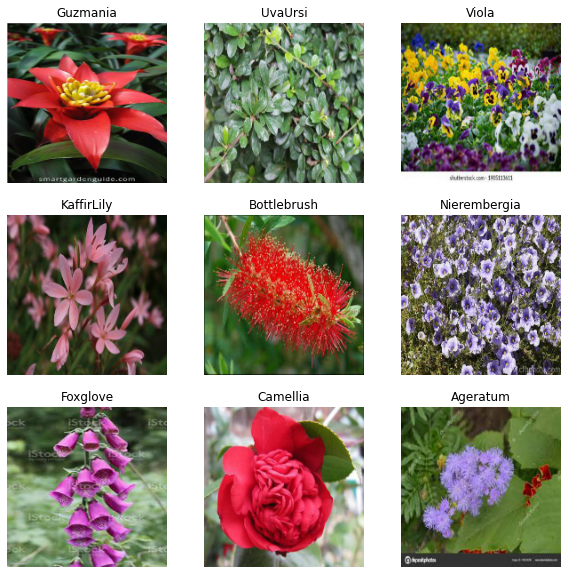

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


2022-01-23 22:08:32.344730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
num_classes = 299

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(
  optimizer='adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/10


2022-01-23 22:08:46.962539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


2899/2899 [==============================] - 49s 13ms/step - loss: 4.7711 - accuracy: 0.0603 - val_loss: 4.2403 - val_accuracy: 0.1164
Epoch 2/10
2899/2899 [==============================] - 42s 14ms/step - loss: 3.7652 - accuracy: 0.1923 - val_loss: 3.7129 - val_accuracy: 0.2056
Epoch 3/10
2899/2899 [==============================] - 44s 15ms/step - loss: 2.8408 - accuracy: 0.3587 - val_loss: 3.4639 - val_accuracy: 0.2973
Epoch 4/10
2899/2899 [==============================] - 48s 16ms/step - loss: 1.9769 - accuracy: 0.5365 - val_loss: 3.3218 - val_accuracy: 0.3759
Epoch 5/10
2899/2899 [==============================] - 46s 16ms/step - loss: 1.3260 - accuracy: 0.6779 - val_loss: 3.4892 - val_accuracy: 0.4472
Epoch 6/10
2899/2899 [==============================] - 42s 14ms/step - loss: 0.8980 - accuracy: 0.7701 - val_loss: 3.8158 - val_accuracy: 0.4850
Epoch 7/10
2899/2899 [==============================] - 44s 15ms/step - loss: 0.6346 - accuracy: 0.8294 - val_loss: 4.3918 - val_accura

### 훈련 결과

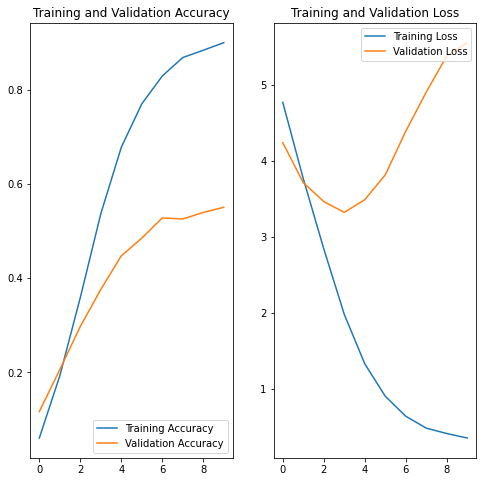

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

과적합이 일어나 Dense 과정 필요, 또한 batch_size 고려필요

### 데이터 증강

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

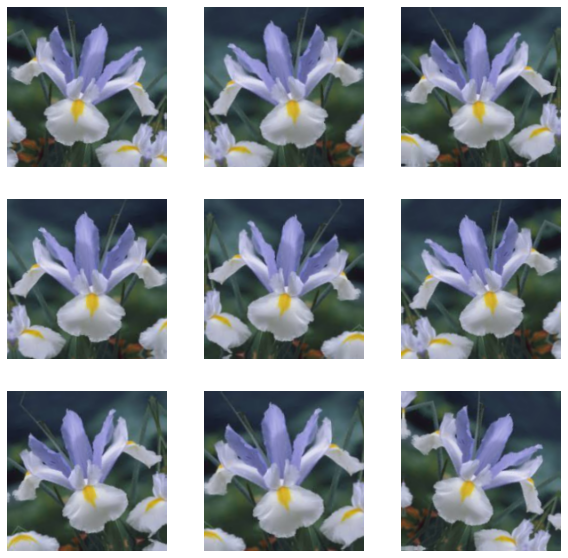

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 드롭아웃

In [28]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### 콜백 설정

In [31]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            min_delta=0,
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto',
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [32]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/50
2899/2899 [==============================] - 49s 17ms/step - loss: 4.8335 - accuracy: 0.0526 - val_loss: 4.3598 - val_accuracy: 0.0982
Epoch 2/50
2899/2899 [==============================] - 45s 16ms/step - loss: 4.2079 - accuracy: 0.1160 - val_loss: 4.0937 - val_accuracy: 0.1363
Epoch 3/50
2899/2899 [==============================] - 46s 16ms/step - loss: 3.9592 - accuracy: 0.1504 - val_loss: 3.8707 - val_accuracy: 0.1677
Epoch 4/50
2899/2899 [==============================] - 47s 16ms/step - loss: 3.7985 - accuracy: 0.1749 - val_loss: 3.7557 - val_accuracy: 0.1837
Epoch 5/50
2899/2899 [==============================] - 47s 16ms/step - loss: 3.6698 - accuracy: 0.1968 - val_loss: 3.6956 - val_accuracy: 0.1964
Epoch 6/50
2899/2899 [==============================] - 45s 15ms/step - loss: 3.5804 - accuracy: 0.2115 - val_loss: 3.5958 - val_accuracy: 0.2166
Epoch 7/50
2899/2899 [==============================] - 43s 15ms/step - loss: 3.5101 - accuracy: 0.2216 - val_loss: 3.6090 -

In [33]:
model.save('model-whole.h5')
model.save_weights('model-weights.h5')

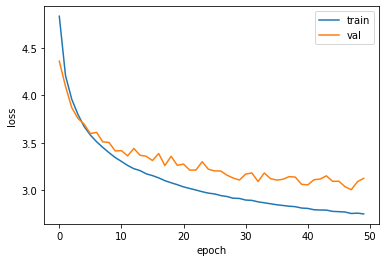

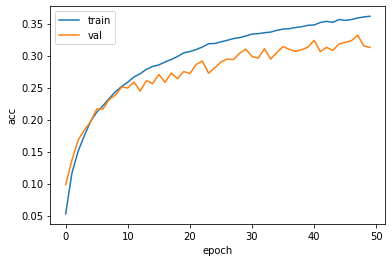

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

정확도가 부족해... VGG19 모델을 써보자..